# Loading and Exploring Data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

data = pd.read_csv("train.csv")

# Explore the data
data.head()


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [6]:
#Finding Null Values
total_null_values = data.isnull().sum().sum()
print(f"Total number of null values in the dataset: {total_null_values}")

Total number of null values in the dataset: 0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

# Visualize distribution of target variable (critical_temp)

The distribution of the target variable, critical_temp, is visualized using a histogram and box plot to understand its spread, skewness, and presence of outliers

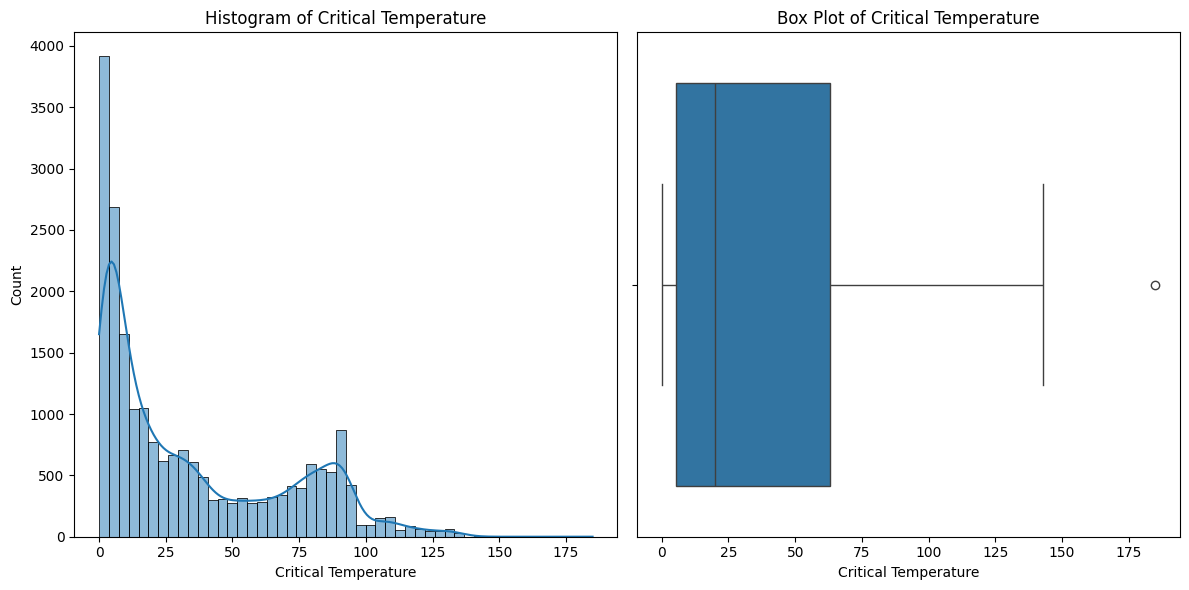

In [8]:
# 2. Discover and Visualize the Data
# Distribution of the target variable: Histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['critical_temp'], bins=50, kde=True)
plt.title("Histogram of Critical Temperature")
plt.xlabel("Critical Temperature")

# Distribution of the target variable: Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=data['critical_temp'])
plt.title("Box Plot of Critical Temperature")
plt.xlabel("Critical Temperature")

plt.tight_layout()
plt.show()


# Handle Skewness and Remove Outlier

**Handling Skewness**: To address skewness in the target variable, a log transformation (log1p) was applied. This transformation ensures that the distribution is more symmetric, which can improve the performance of regression models

**Handling Outliers** : Outliers in the critical_temp variable are detected and removed using the Interquartile Range (IQR) method to prevent their distortion of the model's performance

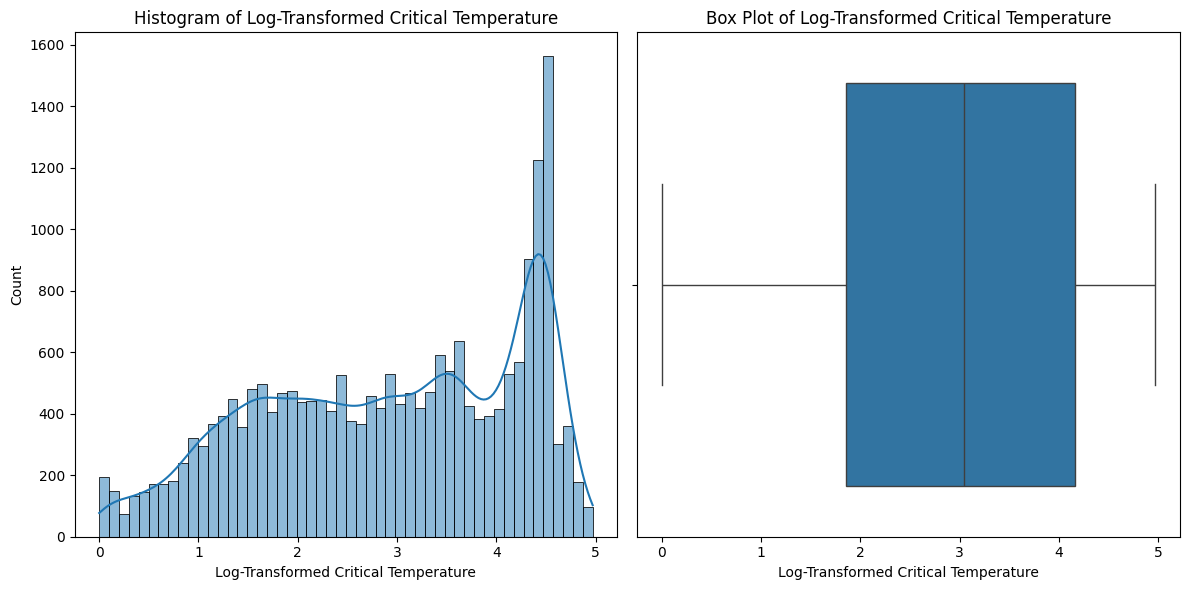

In [9]:
# 1. Detect and Remove Outliers using IQR
Q1 = data['critical_temp'].quantile(0.25)
Q3 = data['critical_temp'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_filtered = data[(data['critical_temp'] >= lower_bound) & (data['critical_temp'] <= upper_bound)].copy()

# 2. Handle Skewness by Applying a Log Transformation
data_filtered['critical_temp_log'] = np.log1p(data_filtered['critical_temp'])  # log(1 + x) to handle zero values

# Visualize the transformed target variable
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data_filtered['critical_temp_log'], bins=50, kde=True)
plt.title("Histogram of Log-Transformed Critical Temperature")
plt.xlabel("Log-Transformed Critical Temperature")

plt.subplot(1, 2, 2)
sns.boxplot(x=data_filtered['critical_temp_log'])
plt.title("Box Plot of Log-Transformed Critical Temperature")
plt.xlabel("Log-Transformed Critical Temperature")

plt.tight_layout()
plt.show()

# Stratified Sampling

**Creating a Categorical Variable**: A categorical variable (temp_category) was created by binning the log-transformed target variable. This variable was used to perform stratified sampling, ensuring that the distribution of the target variable is consistent across the training and test sets.

**Stratified Spli**t: The dataset was split into 80% training and 20% testing sets using StratifiedShuffleSplit. After splitting, the temporary categorical variable and log-transformed target were dropped.

In [10]:
# Ensure the DataFrame has a continuous index
data_filtered = data_filtered.reset_index(drop=True)

# Create a categorical variable by binning the log-transformed target variable
data_filtered['temp_category'] = pd.cut(data_filtered['critical_temp_log'],
                                        bins=[0, 1, 2, 3, 4, 5],
                                        labels=[1, 2, 3, 4, 5])

# Perform stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_filtered, data_filtered['temp_category']):
    strat_train_set = data_filtered.loc[train_index]
    strat_test_set = data_filtered.loc[test_index]

# Drop temp_category and log-transformed column as they were only needed for stratification and skewness handling
for set_ in (strat_train_set, strat_test_set):
    set_.drop(['temp_category', 'critical_temp_log'], axis=1, inplace=True)

# Separate features and target variable
X_train = strat_train_set.drop('critical_temp', axis=1)
y_train = strat_train_set['critical_temp']
X_test = strat_test_set.drop('critical_temp', axis=1)
y_test = strat_test_set['critical_temp']

# Verify the split
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))


Training set size: 17009
Test set size: 4253


# Feature Selection Using Correlation

**Correlation Analysis**: A correlation matrix was computed to identify features most correlated with the target variable (critical_temp). The top 3 features with the highest absolute correlation with the target variable critical_temp are chosen for model training. This approach is useful to reduce dimensionality and focus on the most relevant features, which can help in improving model performance and reducing overfitting

**Visualization**: Scatter plots and a pair plot were used to visualize the relationship between the top features and the target variable. A heatmap was also generated to show the correlations between the selected features.

In [11]:
# Compute correlation with the target variable
corr_matrix = strat_train_set.corr()
corr_target = corr_matrix['critical_temp'].abs()

# Select top 3 correlated features
top_features = corr_target.sort_values(ascending=False).index[1:4]
print("Top 3 correlated features:", top_features)

# Filter the training and test sets based on the selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


Top 3 correlated features: Index(['wtd_std_ThermalConductivity', 'range_ThermalConductivity',
       'range_atomic_radius'],
      dtype='object')


# Visualize the correlation of the top 3 correlated features

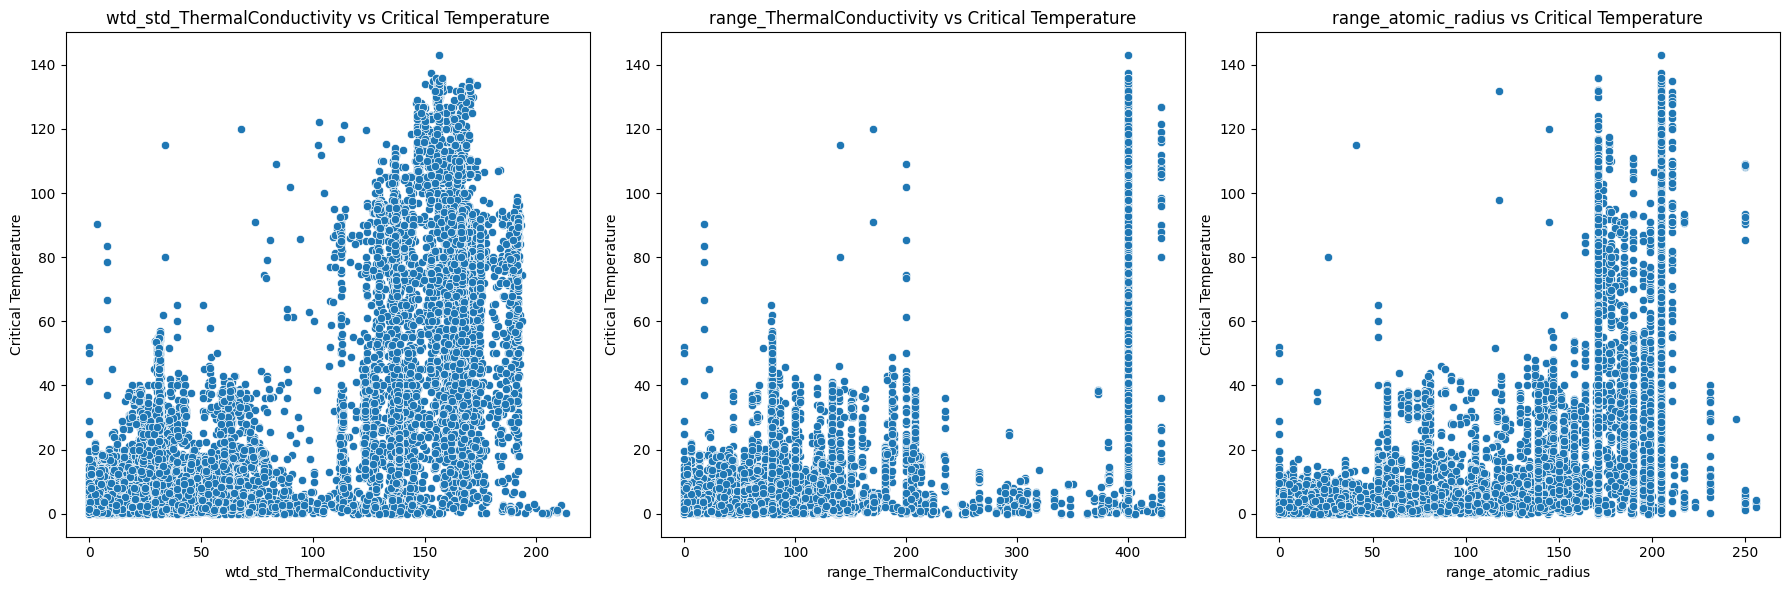

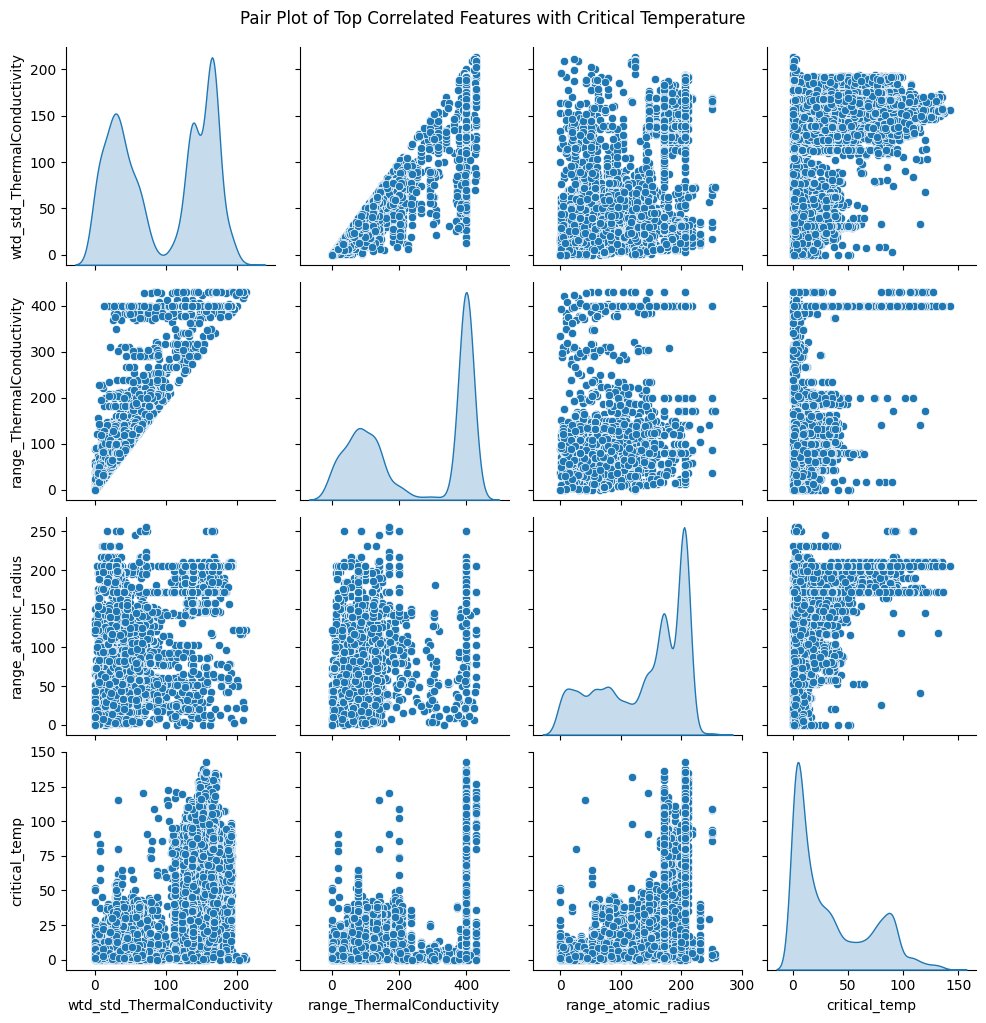

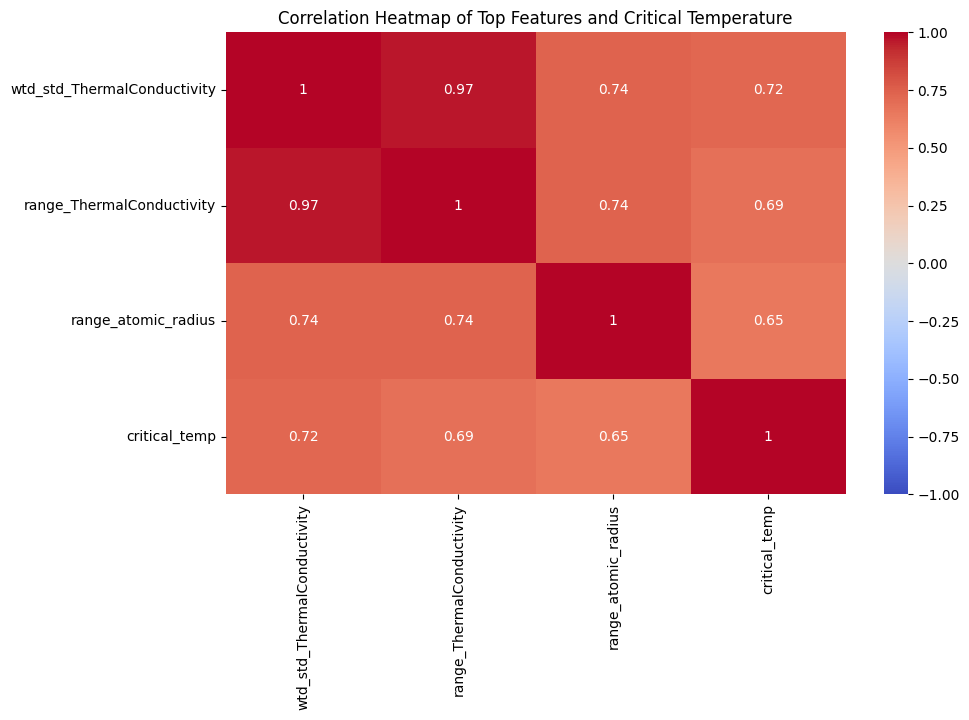

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for each top feature against the target variable
plt.figure(figsize=(18, 6))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=X_train_selected[feature], y=y_train)
    plt.title(f"{feature} vs Critical Temperature")
    plt.xlabel(feature)
    plt.ylabel("Critical Temperature")

plt.tight_layout()
plt.show()

# Combine the selected features with the target variable
df_selected = pd.concat([X_train_selected, y_train], axis=1)

# Pair plot
sns.pairplot(df_selected, diag_kind="kde")
plt.suptitle("Pair Plot of Top Correlated Features with Critical Temperature", y=1.02)
plt.show()

# Correlation matrix for selected features and target variable
corr_matrix_selected = df_selected.corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_selected, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Top Features and Critical Temperature")
plt.show()



# Feature Engineering

**Creating New Features**: A custom FeatureEngineering transformer was implemented to create new features based on interactions between the selected features. Two new features were added: one as the product of two features and another as a quadratic feature.These new features were designed to capture additional relationships and interactions that might improve model performance

In [13]:
# Feature Engineering: Create new features
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, use_new_features=True):
        self.use_new_features = use_new_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.use_new_features:
            # Create new features based on interactions of the top 3 features
            X_new = X.copy()
            X_new['new_feature_1'] = X_new[top_features[0]] * X_new[top_features[1]]
            X_new['new_feature_2'] = X_new[top_features[1]] ** 2 - X_new[top_features[2]]
            return X_new
        else:
            return X

# Apply Feature Engineering to the training and test sets
fe = FeatureEngineering(use_new_features=True)
X_train_fe = fe.transform(X_train_selected)
X_test_fe = fe.transform(X_test_selected)


# Model Training

Three different pipelines are created for Linear Regression, Polynomial Regression, and Random Forest models. Each pipeline includes feature engineering, scaling, and model training steps.

**Linear Regression**: A simple linear regression model was built using the selected and engineered features.

**Polynomial Regression**: A polynomial regression model was implemented using PolynomialFeatures to include interaction terms and higher-degree features.

**Random Forest**: A Random Forest Regressor was built to capture non-linear relationships and interactions between features



In [14]:
# Linear Regression
lr_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Polynomial Regression
poly_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

# Random Forest
rf_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineering()),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the models
lr_pipeline.fit(X_train_fe, y_train)
poly_pipeline.fit(X_train_fe, y_train)
rf_pipeline.fit(X_train_fe, y_train)


Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

# Model Fine Tuning

Hyperparameter Tuning is performed to optimize the model parameters and improve performance.

**Polynomial Regression**: Grid search was used to tune the polynomial degree and the inclusion of new features as a hyperparameter. The goal was to find the best model configuration.

**Random Forest**: Randomized search was used to tune hyperparameters such as the number of estimators, max depth, and minimum samples for splits and leaves. This approach speeds up the process by sampling a random subset of the hyperparameter space.

In [15]:
# Linear Regression Hyperparameter Tuning
param_grid_lr = {
    'feature_engineering__use_new_features': [True, False],  # Whether to use new features
    'scaler': [StandardScaler(), None]  # Option to use or skip scaling
}

grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lr.fit(X_train_fe, y_train)

# Polynomial Regression Hyperparameter Tuning
param_grid_poly = {
    'poly_features__degree': [2, 3, 4],  # Testing higher polynomial degrees
    'feature_engineering__use_new_features': [True, False]
}

grid_search_poly = GridSearchCV(poly_pipeline, param_grid_poly, cv=5, scoring='neg_mean_squared_error')
grid_search_poly.fit(X_train_fe, y_train)

from sklearn.model_selection import RandomizedSearchCV

# Narrowed Random Forest Hyperparameter Grid
param_grid_rf = {
    'model__n_estimators': [100, 200],  # Fewer options for faster tuning
    'model__max_depth': [10, 20],  # Limited depth
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 4],
    'feature_engineering__use_new_features': [True, False]
}

# Use RandomizedSearchCV instead of GridSearchCV
random_search_rf = RandomizedSearchCV(rf_pipeline, param_distributions=param_grid_rf,
                                      n_iter=10,  # Number of parameter settings sampled
                                      cv=3,  # Reduced CV folds
                                      scoring='neg_mean_squared_error',
                                      random_state=42,
                                      n_jobs=-1)  # Use all available cores for parallel processing

random_search_rf.fit(X_train_fe, y_train)

# # Random Forest Hyperparameter Tuning
# param_grid_rf = {
#     'model__n_estimators': [100, 200, 300],  # Increase number of trees
#     'model__max_depth': [10, 20, 30],  # Limit depth to prevent overfitting
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'feature_engineering__use_new_features': [True, False]
# }

# grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
# grid_search_rf.fit(X_train_fe, y_train)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_engineering',
                                              FeatureEngineering()),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'feature_engineering__use_new_features': [True,
                                                                                  False],
                                        'model__max_depth': [10, 20],
                                        'model__min_samples_leaf': [2, 4],
                                        'model__min_samples_split': [5, 10],
                                        'model__n_estimators': [100, 200]},
                   random_state=42, scoring='neg_mean_squared_error')

# Evaluation of the three model performance

The performance of each model is evaluated on the test set using Root Mean Squared Error (RMSE) and (R²) score. This provides insights into the accuracy and explanatory power of each model

1. Performance Before Tuning

In [17]:
# Evaluation on the test set
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    return rmse, r2

# Evaluate each model before tuning
lr_rmse_before, lr_r2_before = evaluate_model(lr_pipeline, X_test_fe, y_test)
poly_rmse_before, poly_r2_before = evaluate_model(poly_pipeline, X_test_fe, y_test)
rf_rmse_before, rf_r2_before = evaluate_model(rf_pipeline, X_test_fe, y_test)

# Print results
print("Linear Regression (Before Tuning) RMSE:", lr_rmse_before, "R^2:", lr_r2_before)
print("Polynomial Regression (Before Tuning) RMSE:", poly_rmse_before, "R^2:", poly_r2_before)
print("Random Forest (Before Tuning) RMSE:", rf_rmse_before, "R^2:", rf_r2_before)


Linear Regression (Before Tuning) RMSE: 21.589229888025653 R^2: 0.5926088176109285
Polynomial Regression (Before Tuning) RMSE: 20.79059866410232 R^2: 0.6221918578551197
Random Forest (Before Tuning) RMSE: 16.894634748071294 R^2: 0.7505204584980126


2. Performance After Tuning

In [18]:
# Evaluate each model
lr_rmse, lr_r2 = evaluate_model(grid_search_lr.best_estimator_, X_test_fe, y_test)
poly_rmse, poly_r2 = evaluate_model(grid_search_poly, X_test_fe, y_test)
rf_rmse, rf_r2 = evaluate_model(random_search_rf.best_estimator_, X_test_fe, y_test)

print("Linear Regression RMSE:", lr_rmse, "R^2:", lr_r2)
print("Polynomial Regression RMSE:", poly_rmse, "R^2:", poly_r2)
print("Random Forest RMSE:", rf_rmse, "R^2:", rf_r2)


Linear Regression RMSE: 21.589229888025653 R^2: 0.5926088176109285
Polynomial Regression RMSE: 20.36257209638434 R^2: 0.6375879801472717
Random Forest RMSE: 15.822621019841751 R^2: 0.7811763915715887


# Model Comparison

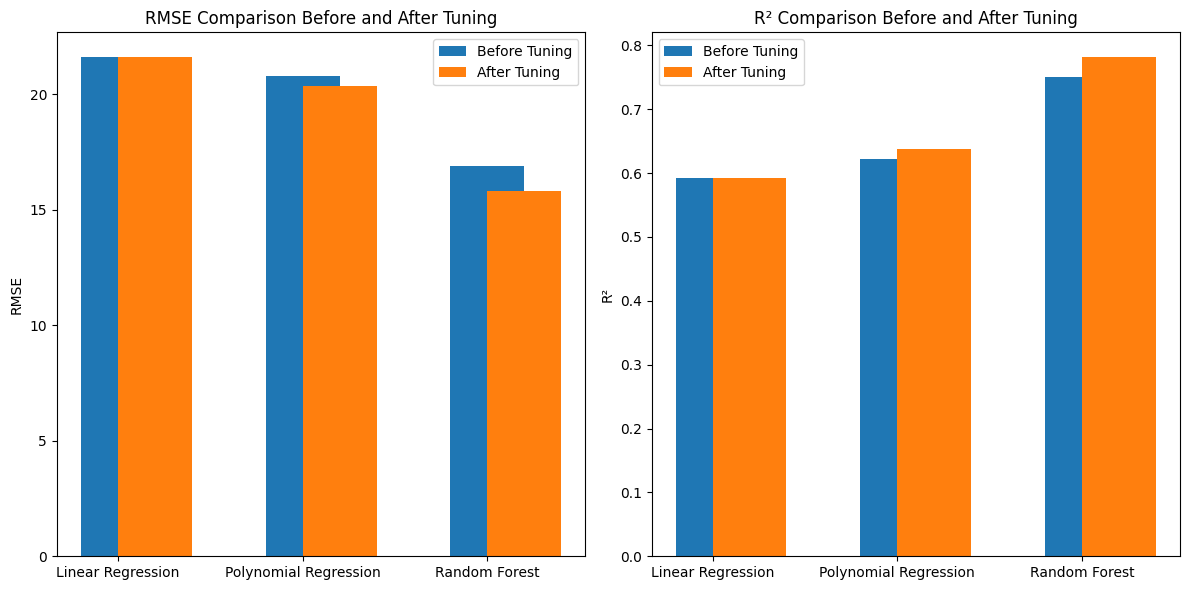

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Store RMSE and R² results for each model
results_after_tuning = {
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'RMSE': [lr_rmse, poly_rmse, rf_rmse],
    'R²': [lr_r2, poly_r2, rf_r2]
}


results_before_tuning = {
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest'],
    'RMSE': [lr_rmse_before, poly_rmse_before, rf_rmse_before],
    'R²': [lr_r2_before, poly_r2_before, rf_r2_before]
}

# Convert to DataFrames for better manipulation
df_before = pd.DataFrame(results_before_tuning)
df_after = pd.DataFrame(results_after_tuning)

# Plot comparison of RMSE before and after tuning
plt.figure(figsize=(12, 6))

# RMSE Comparison
plt.subplot(1, 2, 1)
plt.bar(df_before['Model'], df_before['RMSE'], width=0.4, label='Before Tuning', align='center')
plt.bar(df_after['Model'], df_after['RMSE'], width=0.4, label='After Tuning', align='edge')
plt.title("RMSE Comparison Before and After Tuning")
plt.ylabel("RMSE")
plt.legend()

# R² Comparison
plt.subplot(1, 2, 2)
plt.bar(df_before['Model'], df_before['R²'], width=0.4, label='Before Tuning', align='center')
plt.bar(df_after['Model'], df_after['R²'], width=0.4, label='After Tuning', align='edge')
plt.title("R² Comparison Before and After Tuning")
plt.ylabel("R²")
plt.legend()

plt.tight_layout()
plt.show()



#Model Result Evaluation


**Linear Regression**

Linear Regression captures 59.3% of the variance in critical temperature. However, the RMSE of 21.589 indicates the model has a relatively high prediction error. While it provides a baseline, this model may be too simplistic for capturing the underlying patterns in the dataset, especially given the complex relationships likely present.
Polynomial Regression

**Polynomial Regression**

Evaluation: Polynomial Regression shows a modest improvement over Linear Regression, capturing 63.8% of the variance and reducing the RMSE slightly to 20.363. This suggests that introducing polynomial features helps in modeling some of the non-linear relationships in the data. However, the gains are not substantial, indicating that the model might still struggle with more intricate patterns in the data.
Random Forest

**Random Forest Regression**

 The Random Forest model significantly outperforms both Linear and Polynomial Regression, with an R² of 0.781 and a much lower RMSE of 15.823. This indicates that Random Forest effectively captures the complex interactions and non-linear relationships in the data. Its ability to aggregate results from multiple decision trees makes it more robust and accurate, reducing prediction errors considerably.

**Best Model**: The Random Forest model is the clear winner, showing superior performance with the lowest RMSE and highest R². This makes it the most reliable model for predicting critical temperature in this dataset


